In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

In [2]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(deMULTIplex))
suppressPackageStartupMessages(library(optparse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

In [3]:
opts <- list()
opts$inputdir <- "/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/"
opts$settings <- "/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/gastruloids_scRNAseq/pipeline/processing/settings.R"
opts$experiment <- "MULTI/exp1_d5"
source(opts$settings)

g_meta <- fread('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/sample_metadata.txt.gz')

In [4]:
bar.table <- lapply(c('sample1', 'sample2', 'sample3'), function(s) {
    tmp <- readRDS(paste0(opts$inputdir,opts$experiment,"/",s,"_barTable.rds"))
    tmp$barcode <- paste0(rownames(tmp), '-1')
    tmp$batch <- paste0('exp1_d5_', s)
    return(tmp)
}
                   )
bar.table <- rbindlist(bar.table)

good.bars <- paste("Bar",io$bars_used[[opts$experiment]][['sample1']],sep="")

bar.table <- merge(bar.table, g_meta, by=c("batch", "barcode"), all.x=TRUE, all.y=FALSE)

Warning message in melt(bar.table.hm.sorted, varnames = c("cell", "MULTI_class")):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(bar.table.hm.sorted). In the next version, this warning will become an error.”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


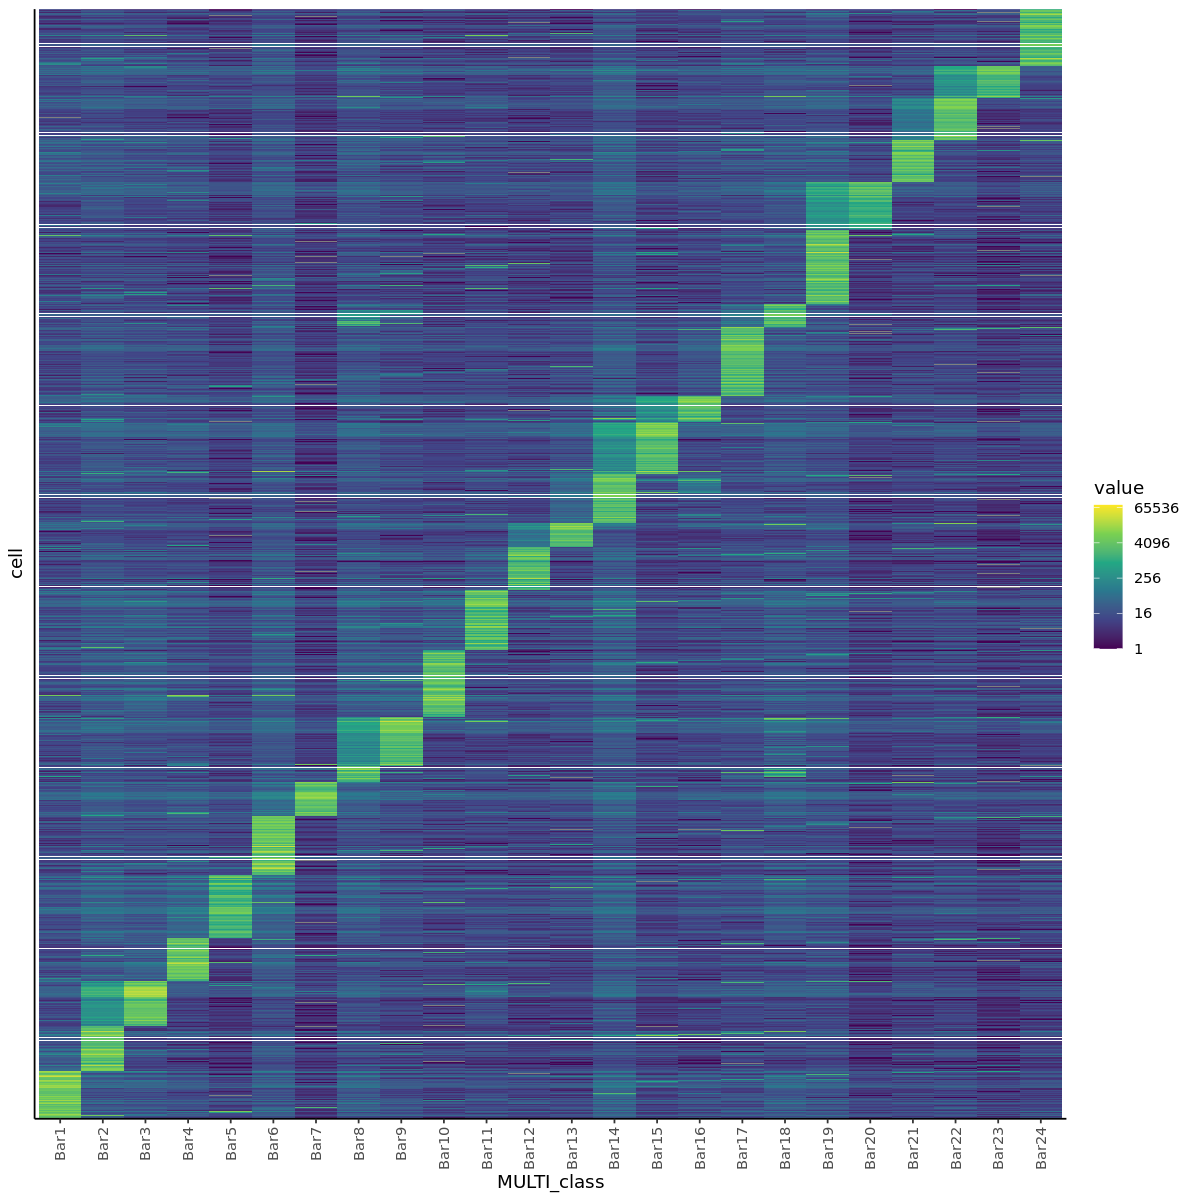

Warning message:
“Transformation introduced infinite values in discrete y-axis”


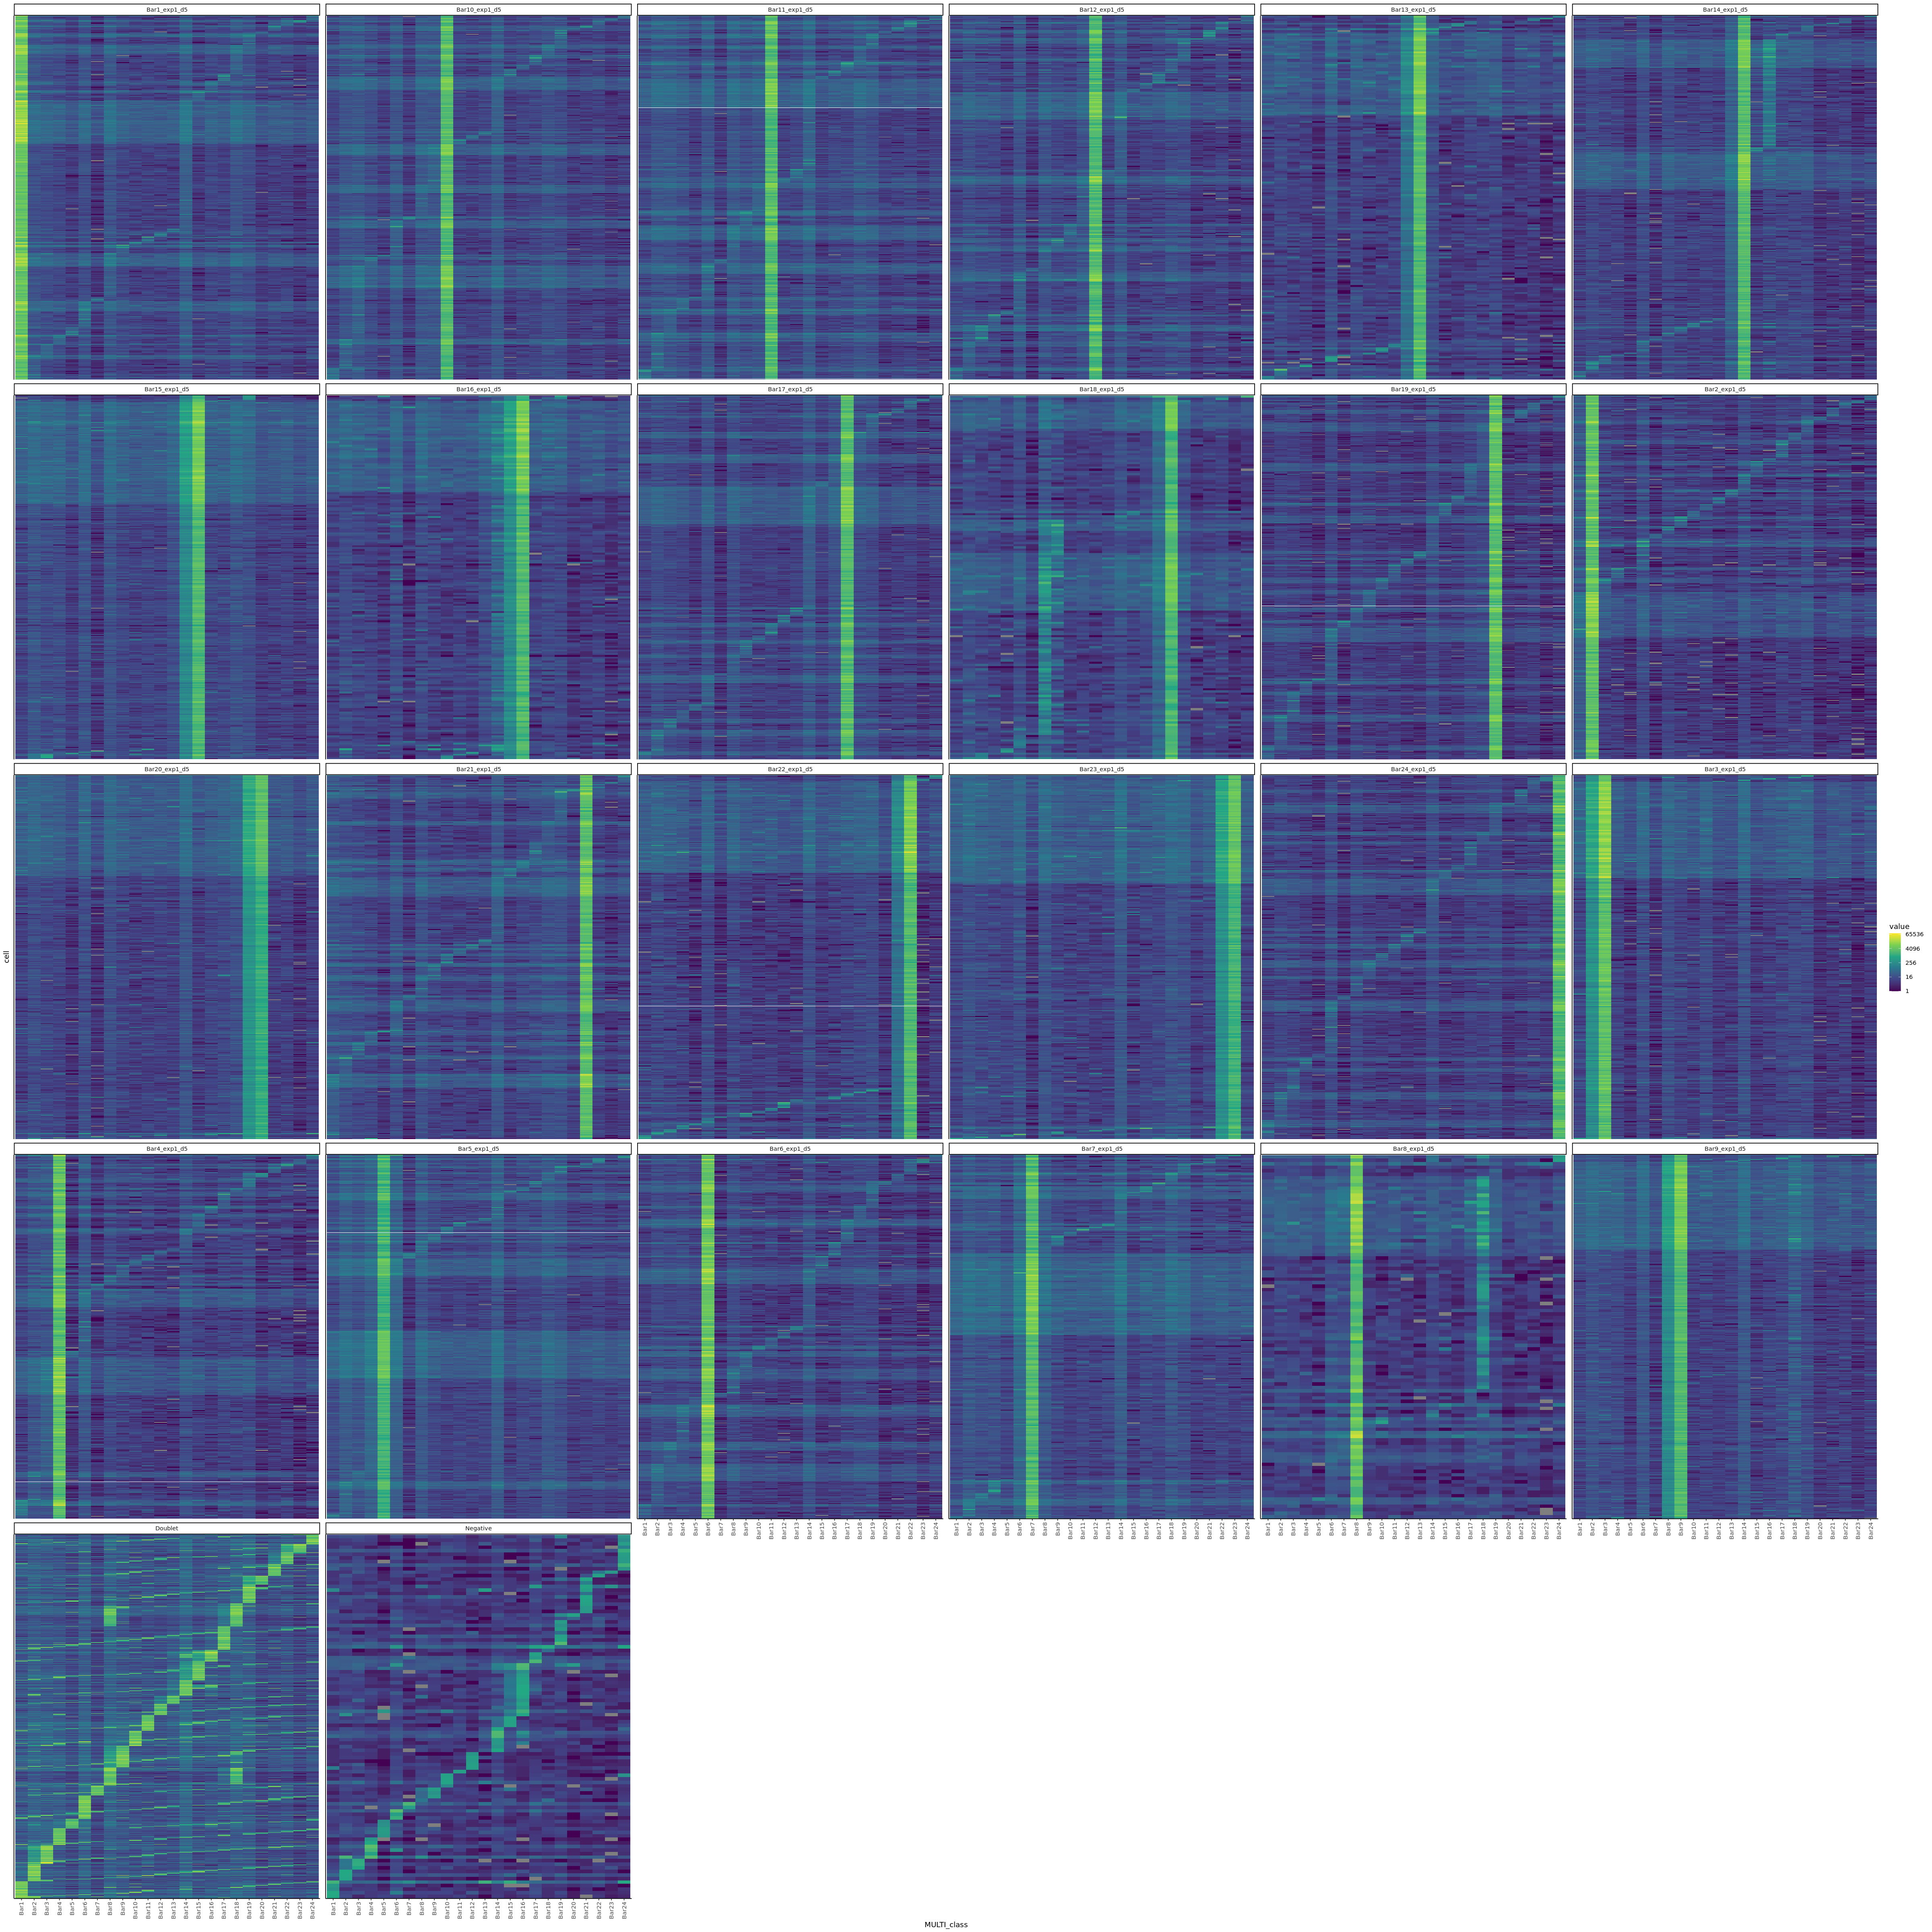

Warning message:
“Transformation introduced infinite values in discrete y-axis”


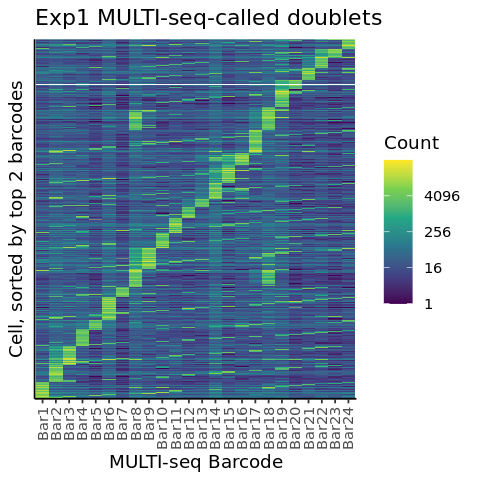

In [7]:
#bar.table.hm <- bar.table[MULTI_class=='Doublet',..good.bars]
bar.table.hm <- bar.table[,..good.bars]
#rownames(bar.table.hm) <- bar.table[MULTI_class=='Doublet']$cell
rownames(bar.table.hm) <- bar.table$cell

argmax <- max.col(bar.table.hm)
bar.table.hm.sorted <- bar.table.hm[sort(argmax, index.return=TRUE)$ix,]
rownames(bar.table.hm.sorted) <- rownames(bar.table.hm)[sort(argmax, index.return=TRUE)$ix]
argmax2 <- max.col(replace(as.matrix(bar.table.hm.sorted), cbind(1:dim(bar.table.hm.sorted)[1], max.col(as.matrix(bar.table.hm.sorted))), -Inf))

sorted_argmax <- max.col(bar.table.hm.sorted)
rns <- rownames(bar.table.hm.sorted)
for (i in unique(argmax)) {
    bar.table.hm.sorted[sorted_argmax==i,] = bar.table.hm.sorted[sorted_argmax==i,][sort(argmax2[sorted_argmax==i], index.return=TRUE)$ix,]
    
    rns[sorted_argmax==i] <- rns[sorted_argmax==i][sort(argmax2[sorted_argmax==i], index.return=TRUE)$ix]
}
bar.table.hm.sorted <- as.matrix(bar.table.hm.sorted)
rownames(bar.table.hm.sorted) <- rns

to.plot <- melt(bar.table.hm.sorted, varnames = c("cell", "MULTI_class"))
to.plot$final_call <- bar.table[match(to.plot$cell, bar.table$cell)]$MULTI_class

options(repr.plot.width=10, repr.plot.height=10)
p <- ggplot(to.plot, aes(MULTI_class, cell, fill= value)) + 
  geom_tile() +
  #scale_fill_gradient( trans = 'log2' ) +
  #scale_fill_gradient(low="white", high="#2171b5", trans = 'log2')
  scale_fill_continuous(type = "viridis", trans = 'log2') +
  theme_classic() +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)

options(repr.plot.width=40, repr.plot.height=40)
p <- ggplot(to.plot, aes(MULTI_class, cell, fill= value)) + 
  geom_tile() +
  #scale_fill_gradient( trans = 'log2' ) +
  #scale_fill_gradient(low="white", high="#2171b5", trans = 'log2')
  scale_fill_continuous(type = "viridis", trans = 'log2') +
  theme_classic() +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  facet_wrap(~final_call, scales = "free_y")
print(p)

options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(to.plot[to.plot$cell %in% g_meta[MULTI_class=="Doublet"]$cell,], aes(MULTI_class, cell, fill= value)) + 
  geom_tile() +
  #scale_fill_gradient( trans = 'log2' ) +
  #scale_fill_gradient(low="white", high="#2171b5", trans = 'log2')
  scale_fill_continuous(type = "viridis", trans = 'log2') +
  ggtitle('Exp1 MULTI-seq-called doublets') +
  labs(x="MULTI-seq Barcode", y="Cell, sorted by top 2 barcodes", fill="Count") +
  theme_classic() +
  theme(axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/D.pdf',
  plot = p,
  device = 'pdf',
  width = 4,
  height = 4,
  units = "in"
)

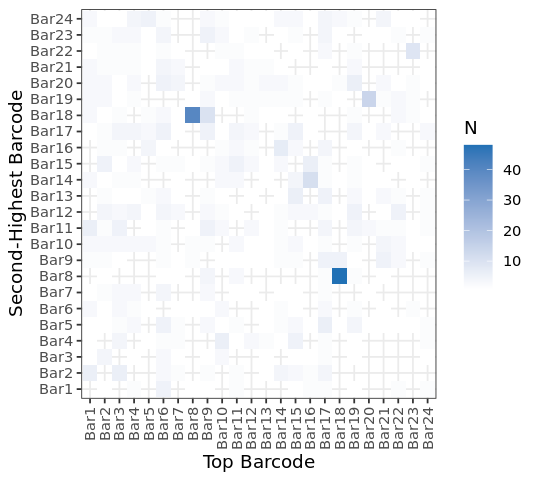

In [6]:
#bar.table.hm <- bar.table[MULTI_class=='Doublet',..good.bars]
bar.table.hm <- bar.table[,..good.bars]
#rownames(bar.table.hm) <- bar.table[MULTI_class=='Doublet']$cell
rownames(bar.table.hm) <- bar.table$cell

argmax <- max.col(bar.table.hm)
bar.table$max_col1 <- good.bars[argmax]
argmax2 <- max.col(replace(as.matrix(bar.table.hm), cbind(1:dim(bar.table.hm)[1], max.col(as.matrix(bar.table.hm))), -Inf))
bar.table$max_col2 <- good.bars[argmax2]

tmp <- bar.table[MULTI_class=='Doublet',.N,by=c("max_col1", "max_col2")]
to.plot <- tmp[order(tmp$N)]
to.plot$max_col1 <- factor(to.plot$max_col1, levels=good.bars)
to.plot$max_col2 <- factor(to.plot$max_col2, levels=good.bars)

options(repr.plot.width=4.5, repr.plot.height=4)
p <- ggplot(to.plot, aes(max_col1, max_col2, fill= N)) + 
  geom_tile() +
  #scale_fill_gradient( trans = 'log2' ) +
  scale_fill_gradient(low="white", high="#2171b5") +
  labs(x="Top Barcode", y="Second-Highest Barcode") +
  #scale_fill_gradient(low="white", high="#67000D") +
  #scale_fill_continuous(type = "viridis", trans = 'log2') +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)

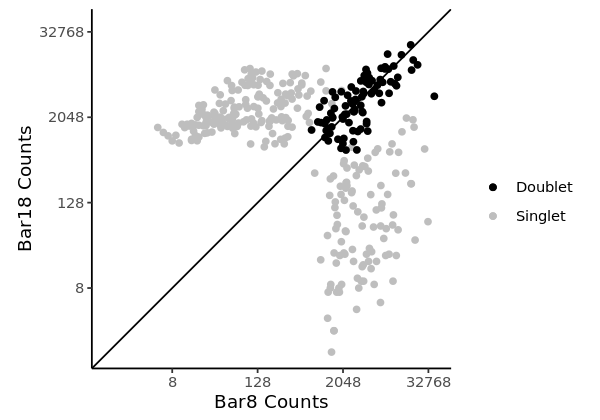

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



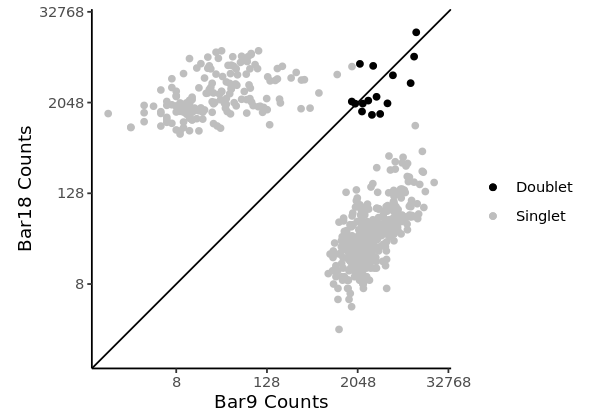

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Warning message:
“Transformation introduced infinite values in continuous y-axis”


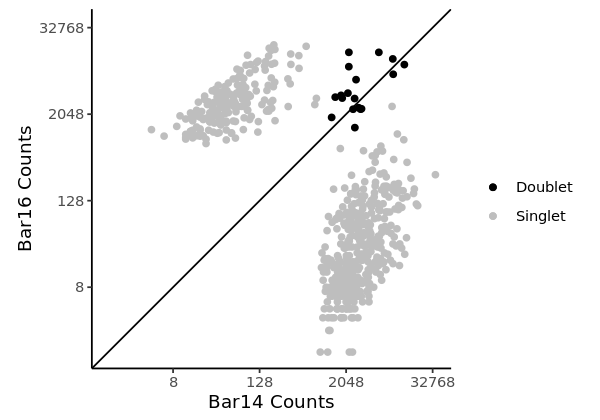

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Warning message:
“Transformation introduced infinite values in continuous y-axis”


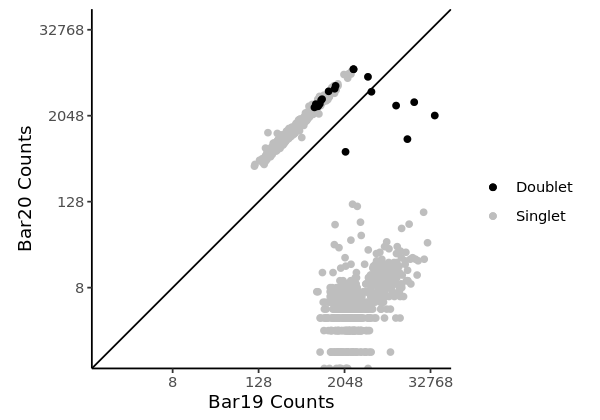

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



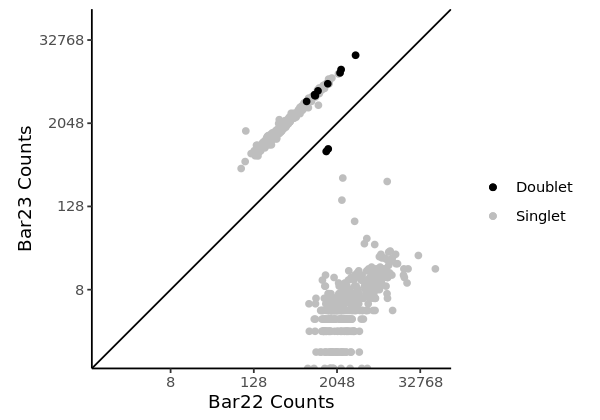

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



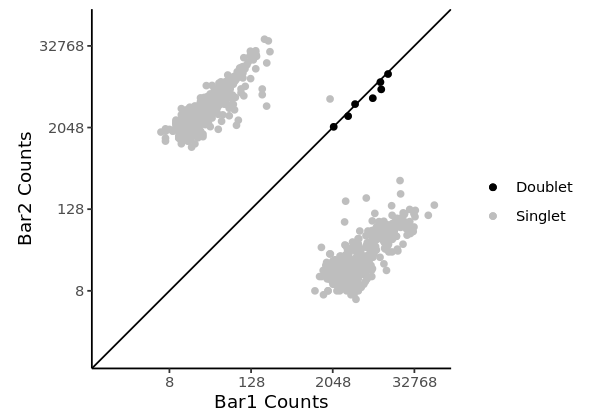

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



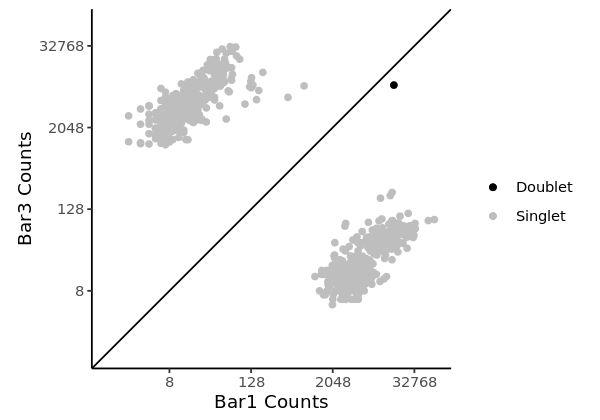

In [ ]:
to.plot <- bar.table[(MULTI_class %in% c("Bar8_exp1_d5", "Bar18_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar8", "Bar18")) & (max_col2 %in% c("Bar8", "Bar18")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar8, Bar18, colour= MULTI_class)) + 
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar8 Counts", y="Bar18 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
#p<-p+tune::coord_obs_pred()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_8_18.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar9_exp1_d5", "Bar18_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar9", "Bar18")) & (max_col2 %in% c("Bar9", "Bar18")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar9, Bar18, colour= MULTI_class)) + 
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar9 Counts", y="Bar18 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
#p<-p+tune::coord_obs_pred()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_9_18.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar14_exp1_d5", "Bar16_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar14", "Bar16")) & (max_col2 %in% c("Bar14", "Bar16")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar14, Bar16, colour= MULTI_class)) + 
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar14 Counts", y="Bar16 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_14_16.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar19_exp1_d5", "Bar20_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar19", "Bar20")) & (max_col2 %in% c("Bar19", "Bar20")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar19, Bar20, colour= MULTI_class)) +
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar19 Counts", y="Bar20 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_19_20.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar22_exp1_d5", "Bar23_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar22", "Bar23")) & (max_col2 %in% c("Bar22", "Bar23")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar22, Bar23, colour= MULTI_class)) + 
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar22 Counts", y="Bar23 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_22_23.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar1_exp1_d5", "Bar2_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar1", "Bar2")) & (max_col2 %in% c("Bar1", "Bar2")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar1, Bar2, colour= MULTI_class)) + 
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar1 Counts", y="Bar2 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_1_2.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar1_exp1_d5", "Bar3_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar1", "Bar3")) & (max_col2 %in% c("Bar1", "Bar3")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar1, Bar3, colour= MULTI_class)) +
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar1 Counts", y="Bar3 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_1_3.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

to.plot <- bar.table[(MULTI_class %in% c("Bar15_exp1_d5", "Bar16_exp1_d5")) | ((MULTI_class == "Doublet") & (max_col1 %in% c("Bar15", "Bar16")) & (max_col2 %in% c("Bar15", "Bar16")))]
options(repr.plot.width=5, repr.plot.height=3.5)
p <- ggplot(to.plot[MULTI_class=="Doublet"], aes(Bar15, Bar16, colour= MULTI_class)) +
  geom_point(data=select(to.plot,-MULTI_class), aes(colour="Singlet")) +
  geom_point(aes(colour="Doublet")) +
  labs(x="Bar15 Counts", y="Bar16 Counts", colour="Gastruloid Assignment") +
  scale_colour_manual(name = "", values = c("Doublet" = "black", "Singlet" = "grey")) +
  geom_abline(intercept = 0, slope=1) +
  coord_fixed() +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(trans='log2') +
  theme_classic()
r<-max(abs(layer_scales(p)$x$range$range))
s<-max(abs(layer_scales(p)$y$range$range))
t<-round(max(r,s),1)
p<-p+coord_equal(xlim=c(1,2^t),ylim=c(1,2^t))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/SuppFig4/F_15_16.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3.5,
  units = "in"
)

In [152]:
tmp <- bar.table[,.N,by=c("MULTI_class")]


p <- matrix(0, nrow = 24, ncol = 24)
rownames(p) <- good.bars
colnames(p) <- good.bars

denom <- sum(tmp[MULTI_class %in% paste0(good.bars, '_exp1_d5')]$N)
for (i in good.bars) {
    for (j in good.bars)
        p[i,j] <- ((tmp[MULTI_class==paste0(i, '_exp1_d5')]$N)/denom) * ((tmp[MULTI_class==paste0(j, '_exp1_d5')]$N)/denom)
}

p[lower.tri(p, diag=TRUE)] <- 0
p <- p/sum(p)

pvals2 <- matrix(0, nrow = 24, ncol = 24)
rownames(pvals2) <- good.bars
colnames(pvals2) <- good.bars
for (i in good.bars) {
    for (j in good.bars) {
        if (which(good.bars == i) < which(good.bars == j)) {
            pvals2[i,j] <- binom.test(nrow(bar.table[(MULTI_class == "Doublet") & (max_col1 %in% c(i, j)) & (max_col2 %in% c(i, j))]),
                                      tmp[MULTI_class=="Doublet"]$N,
                                      p[i, j],
                                      alternative="greater"
                                     )$p.value
        #message(pvals2[i,j])
            if (pvals2[i,j] == 0) {
                print(paste0("i=", i, ", j=", j))
            }
        #}
        }
    }
}
toplot2 <- data.table(reshape2::melt(pvals2, value.name = 'P-value'))[`P-value`>0]
toplot2$`Adjusted P-value` <- p.adjust(toplot2$`P-value`, method="BH")
toplot2 <- toplot2[order(toplot2$`P-value`)]
out <- toplot2[`Adjusted P-value` < 0.1]

In [153]:
out

Var1,Var2,P-value,Adjusted P-value
<fct>,<fct>,<dbl>,<dbl>
Bar8,Bar18,7.583941e-174,2.093168e-171
Bar14,Bar16,2.349384e-12,3.242150e-10
Bar9,Bar18,8.516691e-11,7.835356e-09
Bar19,Bar20,1.245540e-05,8.594224e-04
Bar22,Bar23,4.969813e-05,2.743337e-03
Bar15,Bar16,2.251409e-04,1.035648e-02
Bar8,Bar9,4.749476e-04,1.872651e-02
Bar2,Bar3,1.936970e-03,6.682547e-02
